## План
Мы **подготовим данные** с торговой площадки с лотами вторичной недвижимости (квартиры) в европейском мегаполисе для того, чтобы с помощью методов моделирования и анализа данных **определить значимые для цены факторы** этой недвижимости.

**Подготовка данных:**
* Заполнение и обработка пропусков и подозрительных данных
* Предварительный разведывательный анализ данных:
    * Распределение абсолютных цен лотов
    * Распределение цен на метр площади лотов
    * Распределение количества комнат и площади лотов
* Генерация признаков на основе имеющихся данных и сохранение полученных признаков

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import statsmodels
PATH_TO_RAW_DATA = '../data/raw/'
PATH_TO_INTER_DATA = '../data/intermediate/'
PATH_TO_PROCESSED_DATA = '../data/'
PATH_TO_IMAGES = '../imgs/'

import re
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
df = pd.read_excel(PATH_TO_RAW_DATA + 'parsing_cian.xls', encoding='ascii', na_rep =np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14351 entries, 0 to 14350
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ссылка            14351 non-null  object 
 1   Адрес             14330 non-null  object 
 2   Площадь           14330 non-null  float64
 3   Кол-во комнат     13667 non-null  object 
 4   Этаж              14329 non-null  float64
 5   Этажей в доме     14329 non-null  float64
 6   Метро             13789 non-null  object 
 7   Расст-е до метро  13542 non-null  object 
 8   Тип дома          10655 non-null  object 
 9   Санузел           12179 non-null  object 
 10  Балкон            9217 non-null   object 
 11  Ремонт            12081 non-null  object 
 12  Окна              9830 non-null   object 
 13  Год постройки     11061 non-null  float64
 14  Жилая площадь     11742 non-null  float64
 15  Площадь кухни     11809 non-null  float64
 16  Цена              14330 non-null  float6

In [3]:
df['Цена за метр'] = df['Цена'] / df['Площадь']

In [4]:
df.head(3)

,Ссылка,Адрес,Площадь,Кол-во комнат,Этаж,Этажей в доме,Метро,Расст-е до метро,Тип дома,Санузел,Балкон,Ремонт,Окна,Год постройки,Жилая площадь,Площадь кухни,Цена,Цена за метр
0,https://cian.ru/sale/flat/229751453/,"Москва, ВАО, р-н Гольяново, Байкальская ул., 42К2",33.0,1,9.0,9.0,Первомайская,15 мин. пешком,Монолитный,1 совмещенный,NaN,Без ремонта,Во двор,1969.0,16.0,7.0,5990000.0,181515.151515
1,https://cian.ru/sale/flat/228346306/,"Москва, ЮЗАО, р-н Зюзино, ул. Каховка, 13К2",32.0,1,4.0,9.0,Чертановская,12 мин. пешком,Блочный,1 совмещенный,1 балкон,Косметический,NaN,1963.0,22.0,6.0,6790000.0,212187.500000
2,https://cian.ru/sale/flat/227956176/,"Москва, ЗАО, р-н Кунцево, Истринская ул., 10К1",33.0,1,9.0,9.0,Молодежная,15 мин. пешком,Панельный,1 совмещенный,NaN,Дизайнерский,Во двор,1968.0,19.5,7.1,7190000.0,217878.787879


Посмотрим на количество пропусков по признакам лотов

In [5]:
df.isna().sum()

Ссылка                 0
Адрес                 21
Площадь               21
Кол-во комнат        684
Этаж                  22
Этажей в доме         22
Метро                562
Расст-е до метро     809
Тип дома            3696
Санузел             2172
Балкон              5134
Ремонт              2270
Окна                4521
Год постройки       3290
Жилая площадь       2609
Площадь кухни       2542
Цена                  21
Цена за метр          21
dtype: int64

### Почистим наши данные и обработаем пропуски
* Удалим лоты без адреса (21 лот, не известна ни одна характеристика)
* Удалим лоты без этажа (1 лот с большой площадью в центре под офис)

* Заполним эвристиками (на основе распределений цен по известным) пропуски в поле `Кол-во комнат`:
    * **все** лоты меньше $31$ метров площади отнесем к категории `Студия или Апартаменты` (`СиА`), туда же отнесем недвижимость классифицированную дающим объявление, как `Аппартаменты`)
    * лоты с пропуском числа комнат и площадью до $42$ метров отнесем к категории `однокомнатные` (только $12%$ двухкомнатных меньше этого размера площади)
    * лоты с пропуском числа комнат и площадью до $70$ метров отнесем к категории `двухкомнатные` (только $20%$ трехкомнатных меньше этого размера площади)
    * лоты с пропуском числа комнат и площадью до $110$ метров отнесем к категории `трехкомнатные` (только $25%$ четырехкомнатных меньше этого размера площади)
    * лоты с пропуском числа комнат и площадью до $140$ метров отнесем к категории `четырехкомнатные` (только $25%$ пятикомнатных меньше этого размера площади)
    * остальные лоты с пропусками числа комнат отнесем к пятикомнатным
    * **все** лоты площадью больше $190$ метров отнесем к категории `Многокомнатная или свободная планировка` (`МиСП`)
    
* Заменим указание на еще не открывшиеся станции метро (`откроется в X`) в поле с расстоянием до метро на `NaN` (11 лотов)

In [6]:
def nans_processing(df : pd.DataFrame):
    '''
    Обрабатываем пропуски в важных колонках
    * Этаж, Адрес -- удаляем пропуски 
    * Расстояние -- переводим пропуск из пустой строки в np.nan
    * Кол-во комнат -- заполняем на основа квантилей известной выборки
    '''
    logging.info('Обработка пропусков: старт')
    df = df[(~df['Адрес'].isna())]
    df = df[(~df['Этаж'].isna())]
    
    # 2. кол-во комнат
    ## квартиры меньше 31 метра отнесем к студиям и аппартаментам
    df.loc[df['Площадь'] <= 31, 'Кол-во комнат'] = 'СиА'
    df.loc[(df['Площадь'] <= 42) & (df['Кол-во комнат'].isna()), 'Кол-во комнат'] = 1
    df.loc[(df['Площадь'] <= 70) & (df['Кол-во комнат'].isna()), 'Кол-во комнат'] = 2
    df.loc[(df['Площадь'] <= 110) & (df['Кол-во комнат'].isna()), 'Кол-во комнат'] = 3
    df.loc[(df['Площадь'] <= 140) & (df['Кол-во комнат'].isna()), 'Кол-во комнат'] = 4
    df.loc[(df['Площадь'] < 200) & (df['Кол-во комнат'].isna()), 'Кол-во комнат'] = 5
    df.loc[df['Кол-во комнат'] == 'Апартаменты', 'Кол-во комнат'] = 'СиА'
    ## удалим подозрительные объявления
    df.loc[(df['Площадь'] > 200) & (df['Кол-во комнат'] == 2)].dropna(inplace=True)
    ## квартиры больше 190 метров отнесем к 'многоквартирым или свободной планировке'
    df.loc[df['Площадь'] >= 190, 'Кол-во комнат'] = 'МиСП'
    
    df.loc[~df['Расст-е до метро'].str.contains('мин', na=True), 'Расст-е до метро'] = np.nan
    
    logging.info('Обработка пропусков: завершение')
    return df

In [7]:
df = nans_processing(df)

assert df.isna().sum().sum() < 28396, 'Пропуски не были удалены'

INFO:root:Обработка пропусков: старт
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:root:Обработка пропусков: завершение


***

### Посмотрим на характеристики лотов
* Рассматрим распределение **абсолютной цены**
* Рассматрим распределение **цены за метр**
* Рассматрим распределение **кол-ва комнат и площади**

> Цены
* Целевая переменная
* Также, на графике без логорифма ограничим верхнее значение $95\%$-ым квантилем по переменной ($95\%$ значений его не превышают)

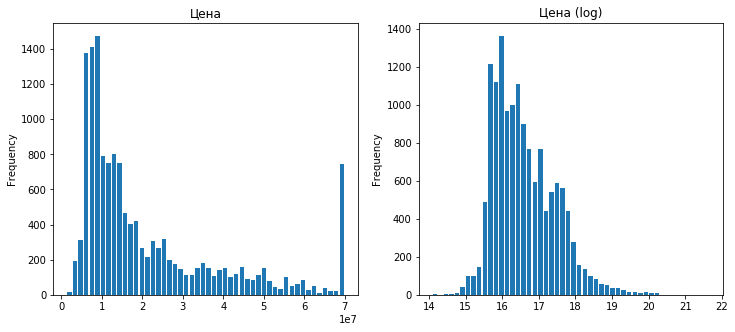

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0] = np.clip(df['Цена'], 0, df['Цена'].quantile(0.95)).plot.hist(bins=50, rwidth=0.8, ax=ax[0], title='Цена')
ax[1] = df['Цена'].apply(np.log).plot.hist(bins=50, rwidth=0.8, ax=ax[1], title='Цена (log)')

plt.savefig(PATH_TO_IMAGES + 'Цены за метр')

> Цены за единицу площади
* Целевая переменная
* Также, на графике без логорифма ограничим верхнее значение $99\%$-ым квантилем по переменной ($99\%$ значений его не превышают)

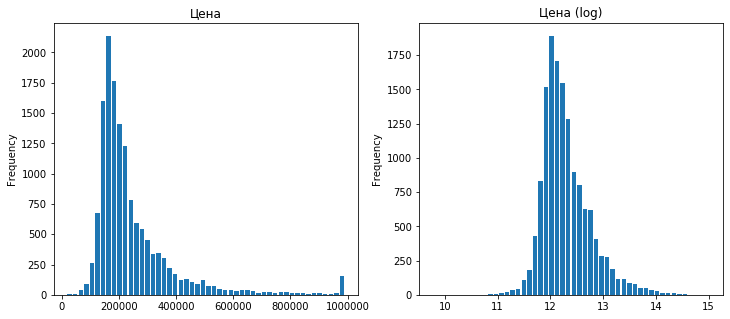

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0] = np.clip((df['Цена'] / df['Площадь']), 0, (df['Цена'] / df['Площадь']).quantile(0.99)).plot.hist(bins=50, rwidth=0.8, ax=ax[0], title='Цена')
ax[1] = (df['Цена'] / df['Площадь']).apply(np.log).plot.hist(bins=50, rwidth=0.8, ax=ax[1], title='Цена (log)')

plt.savefig(PATH_TO_IMAGES + 'Цены за метр')

> Число комнат и площади
* В выборке преобладают квартиры из 3 комнат, площадью 100 метров
* Медианное значение площади $75$ метров, 
* $1/10$ доля всех лотов не превышает 35 метров, а $90\%$ лотов не превышают $150$ метров

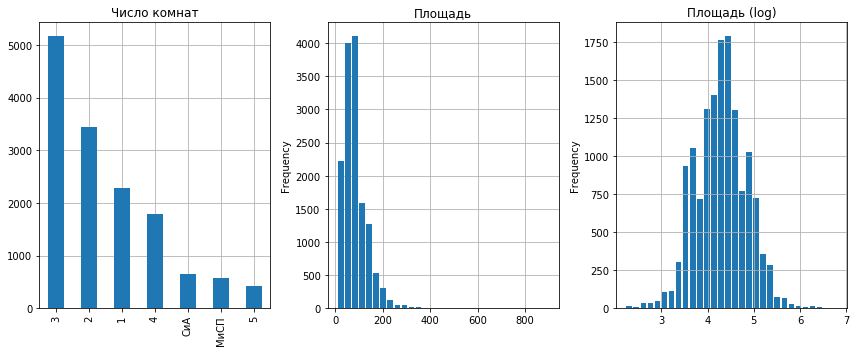

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0] = df['Кол-во комнат'].value_counts().plot.bar(ax=ax[0], title='Число комнат', zorder=2)
ax[0].grid(True)
ax[1] = df['Площадь'].plot.hist(bins=30, rwidth=0.8, ax=ax[1], title='Площадь', zorder=2)
ax[1].grid(True)
ax[2] = df['Площадь'].apply(np.log).plot.hist(bins=30, rwidth=0.8, ax=ax[2], title='Площадь (log)')
ax[2].grid(True)
plt.tight_layout()

plt.savefig(PATH_TO_IMAGES + 'Число комнат и площади')

Также, посмотрим на площадь в зависимости от числа комнат.
* Интересно, что категория Студии и Апартаменты занимает наименьшую площадь, но распределение цен квадратного метра в них правее (значения больше), чем, например, в квартирах с 1 или даже 2 комнатами (вероятно, причина в имеющейся выборке и другим характеристикам этой категории)

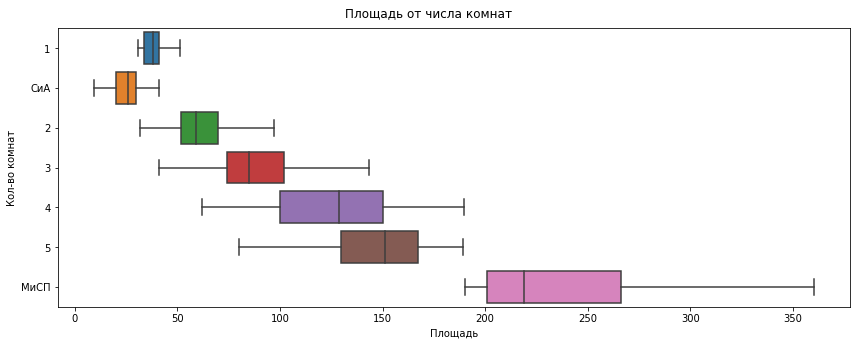

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.boxplot(y='Кол-во комнат', x='Площадь', data=df, showfliers=False)
plt.suptitle('Площадь от числа комнат');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(PATH_TO_IMAGES + 'Площадь и число комнат')

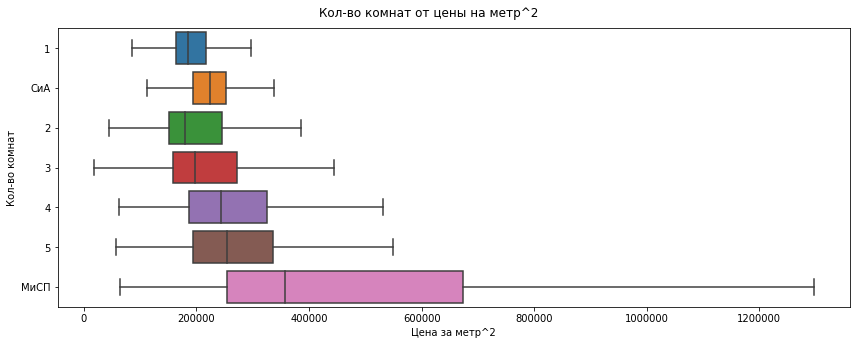

In [26]:
# sns.boxplot(y='Кол-во комнат', x='Цена за метр^2', data=pd.concat([df, df_feature_generated], axis=1), showfliers=False)

***

### Расширим наше признаковое пространство
Сгенерируем дополнительные признаки на основе имеющихся данных
<img src="https://sun9-40.userapi.com/c857628/v857628789/1f0c46/eSwQt6LHzSg.jpg" alt="Список признаков" style="width:500px;height:600px;">

In [13]:
df.head(1)

,Ссылка,Адрес,Площадь,Кол-во комнат,Этаж,Этажей в доме,Метро,Расст-е до метро,Тип дома,Санузел,Балкон,Ремонт,Окна,Год постройки,Жилая площадь,Площадь кухни,Цена,Цена за метр
0,https://cian.ru/sale/flat/229751453/,"Москва, ВАО, р-н Гольяново, Байкальская ул., 42К2",33.0,1,9.0,9.0,Первомайская,15 мин. пешком,Монолитный,1 совмещенный,NaN,Без ремонта,Во двор,1969.0,16.0,7.0,5990000.0,181515.151515


In [14]:
def feature_generation(df : pd.DataFrame):
    '''
    Генерируем вспомогательные признаки по плану из статьи
    https://sun9-40.userapi.com/c857628/v857628789/1f0c46/eSwQt6LHzSg.jpg
    Также, дополнительные признаки
    '''
    df_aux = pd.DataFrame([])
    logging.info('Генерация признаков: старт')
    
    df_aux['Цена за метр^2'] = df['Цена'] / df['Площадь']
    df_aux['Площадь лог'] = np.log(df['Площадь'])
    
    df_aux['Округ'] = df['Адрес'].str.extract('(?:.+?),(.+?),')[0].str.strip()
    df_aux['Район'] =df['Адрес'].str.extract('(?:.+?),(?:.+?),(.+?),')[0].str.strip()
    df_aux['Первый этаж'] = df['Этаж'] == 1
    df_aux['Последний этаж'] = df['Этаж'] == df['Этажей в доме']
    # 9. 541 пропуск станции метро -- можно попробовать подгрузить из api навигаторов и карт
    # 10. 787 пропуск расстояния до метро -- можно попробовать подгрузить из api навигаторов и карт
    df_aux['Расстояние до метро (ед)'] = df['Расст-е до метро'].str.extract('(\d*)')
    df_aux['Расстояние указано пешком'] = df['Расст-е до метро'].str.contains('пешком', na=False)
    df_aux['Расстояние указано на транспорте'] = df['Расст-е до метро'].str.contains('трансп', na=False)
    # 11. 3675 пропуск типа дома -- можно попробовать подгрузить из кадастрового реестра
    # 12. 2151 пропуск в санузлах
    df_aux['Указан раздельный санузел'] = df['Санузел'].str.contains('раздельн', na=False)
    df_aux['Несколько санузлов'] = df['Санузел'].str.contains('(?:[-2])|,', na=False)
    # 13. 5112 пропуск в балконах
    df_aux['Балкон указан'] = ~df['Балкон'].isna()
    # 14. 4500 пропуск в окнах
    df_aux['Окна во двор'] = df['Окна'].isin(['Во двор', 'На улицу и двор'])
    df_aux['Наличие ремонта'] = df['Ремонт'] != 'Без ремонта'
    # 16. 3269 пропуск в возрасте дома -- можно попробовать подгрузить из кадастрового реестра
    df_aux['Возраст дома'] = pd.to_datetime('today').year - df['Год постройки']
    # 17. 2587 пропуск в жилой площади -- можно заполнять на основе распределений в выборке
    df_aux['Доля жилой площади'] = df['Жилая площадь'] / df['Площадь']
    df_aux['Доля куханной площади'] = df['Площадь кухни'] / df['Площадь']
    # 18. 2520 пропуск в площади кухни -- можно заполнять на основе распределений в выборке
    logging.info('Генерация признаков: завершение')
    
    logging.info('Генерация признаков: сохрнение в отдельный файл')
    df_aux.to_csv(PATH_TO_INTER_DATA + 'generated_features' + '.csv')
    
    return df_aux

In [15]:
%time
df_feature_generated = feature_generation(df)
assert df.shape[0] == df_feature_generated.shape[0], 'Количество строк в исходном и сгенерированном файлах не равно'

df_feature_generated.head(3)

INFO:root:Генерация признаков: старт
INFO:root:Генерация признаков: завершение
INFO:root:Генерация признаков: сохрнение в отдельный файл


Wall time: 0 ns


,Цена за метр^2,Площадь лог,Округ,Район,Первый этаж,Последний этаж,Расстояние до метро (ед),Расстояние указано пешком,Расстояние указано на транспорте,Указан раздельный санузел,Несколько санузлов,Балкон указан,Окна во двор,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади
0,181515.151515,3.496508,ВАО,р-н Гольяново,False,True,15,True,False,False,False,False,True,False,51.0,0.484848,0.212121
1,212187.500000,3.465736,ЮЗАО,р-н Зюзино,False,False,12,True,False,False,False,True,False,True,57.0,0.687500,0.187500
2,217878.787879,3.496508,ЗАО,р-н Кунцево,False,True,15,True,False,False,False,False,True,True,52.0,0.590909,0.215152


Посмотрим на полученные колонки сгенерированных признаков

In [16]:
df_feature_generated.columns

Index(['Цена за метр^2', 'Площадь лог', 'Округ', 'Район', 'Первый этаж',
       'Последний этаж', 'Расстояние до метро (ед)',
       'Расстояние указано пешком', 'Расстояние указано на транспорте',
       'Указан раздельный санузел', 'Несколько санузлов', 'Балкон указан',
       'Окна во двор', 'Наличие ремонта', 'Возраст дома', 'Доля жилой площади',
       'Доля куханной площади'],
      dtype='object')

Посмотрим на колонки базовых признаков

In [17]:
df.columns

Index(['Ссылка', 'Адрес', 'Площадь', 'Кол-во комнат', 'Этаж', 'Этажей в доме',
       'Метро', 'Расст-е до метро', 'Тип дома', 'Санузел', 'Балкон', 'Ремонт',
       'Окна', 'Год постройки', 'Жилая площадь', 'Площадь кухни', 'Цена',
       'Цена за метр'],
      dtype='object')

***

Подведём список всех доступных, начальных и полученных, первично предобработанных признаков (`feature_columns`), значимость которых на цену предложения (либо абсолютную, либо за единицу площади; `target_column`) будем измерять при моделировании.

In [18]:
feature_columns = ['Округ', 'Район', 
                   'Площадь', 'Площадь лог', 'Кол-во комнат', 'Этаж', 'Этажей в доме', 'Первый этаж', 'Последний этаж',
                   'Метро', 'Расстояние до метро (ед)', 'Расстояние указано пешком', 'Расстояние указано на транспорте',
                   'Тип дома', 'Указан раздельный санузел', 'Несколько санузлов', 'Балкон указан', 
                   'Окна', 'Окна во двор',
                   'Ремонт', 'Наличие ремонта', 'Возраст дома', 
                   'Доля жилой площади', 'Доля куханной площади', 'Площадь кухни'
                  ]
target_column = ['Цена за метр^2', 'Цена']

Еще раз проверим распределение числа пропусков в предобработанном наборе данных

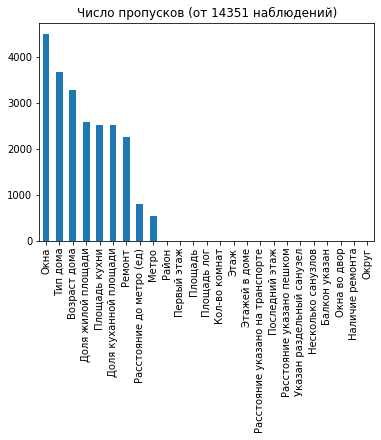

In [19]:
pd.concat([df, df_feature_generated], axis=1)[feature_columns].isna().sum()\
    .sort_values(ascending=False).plot.bar(title='Число пропусков (от 14351 наблюдений)')

Сохраним в отдельный файл, с которым будем работать при моделировании

In [20]:
%time
pd.concat([df, df_feature_generated], axis=1)[feature_columns].to_csv(PATH_TO_PROCESSED_DATA + 'features_dataset' + '.csv')
pd.concat([df, df_feature_generated], axis=1)[target_column].to_csv(PATH_TO_PROCESSED_DATA + 'target_column' + '.csv')

Wall time: 0 ns
